In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gp
import seaborn as sns
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import geopandas
import matplotlib.pyplot as plt
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
df=pd.read_csv("C:\\Users\\Manish\\Downloads\\uber-raw-data-jun14.csv")
df1 = df.copy().iloc[:100000][['Lat','Lon']]
df1.shape

(100000, 2)

In [3]:
df1.head()

,Lat,Lon
0,40.7293,-73.9920
1,40.7131,-74.0097
2,40.3461,-74.6610
3,40.7555,-73.9833
4,40.6880,-74.1831


# Task 1

In [5]:
gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.Lon, df.Lat))

In [6]:
print(gdf.head())


          Date/Time      Lat      Lon    Base                    geometry
0  6/1/2014 0:00:00  40.7293 -73.9920  B02512  POINT (-73.99200 40.72930)
1  6/1/2014 0:01:00  40.7131 -74.0097  B02512  POINT (-74.00970 40.71310)
2  6/1/2014 0:04:00  40.3461 -74.6610  B02512  POINT (-74.66100 40.34610)
3  6/1/2014 0:04:00  40.7555 -73.9833  B02512  POINT (-73.98330 40.75550)
4  6/1/2014 0:07:00  40.6880 -74.1831  B02512  POINT (-74.18310 40.68800)


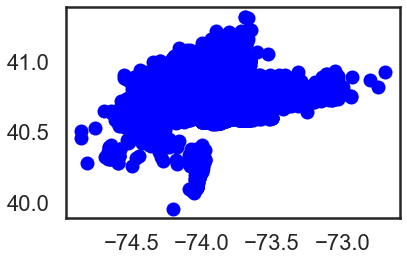

In [7]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'New York'].plot(color='white', edgecolor='black')

gdf.plot(ax=ax, color='blue')

plt.show()


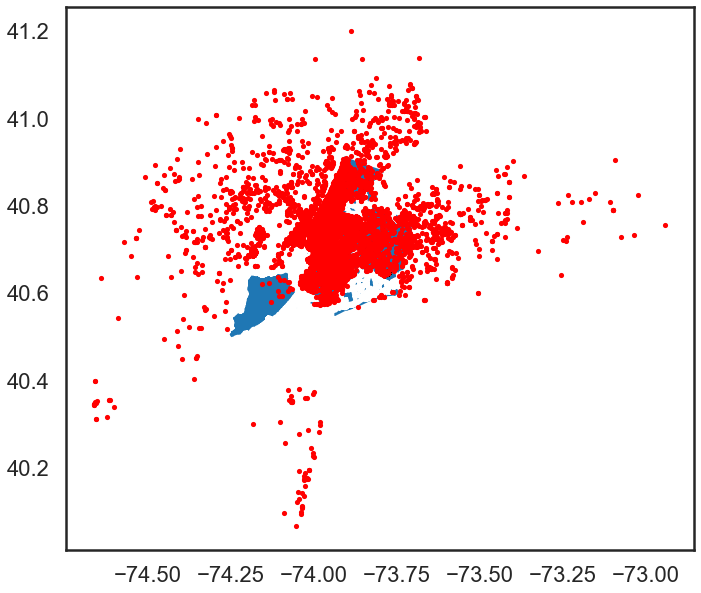

In [8]:
geometry=[Point(x,y) for x,y in zip(df1['Lon'],df1['Lat'])]
plotter=gp.GeoDataFrame(df1,geometry=geometry,crs=4326)

import geoplot as gplt                                       
nyc=gp.read_file(gplt.datasets.get_path('nyc_boroughs'))
plotter.plot(ax=nyc.plot(figsize=(20,10)),c='red',marker='o',markersize=10);

Most of the trips are starting at the centre of the map.

Outliers are scattered on the outskirts of the city.


# Task 2

In [9]:
da=plotter["geometry"].to_crs('epsg:3857')

len=[]
for x,y in zip(da.x,da.y):
    len.append([x,y])
len=pd.DataFrame(len,columns=["Lon_meters","Lat_meters"])
len.head()

,Lon_meters,Lat_meters
0,-8.236752e+06,4.972495e+06
1,-8.238722e+06,4.970116e+06
2,-8.311225e+06,4.916365e+06
3,-8.235783e+06,4.976345e+06
4,-8.258025e+06,4.966430e+06


In [10]:
minmax=MinMaxScaler()
lat_lon=pd.DataFrame(minmax.fit_transform(len),columns=["Lon_meters","Lat_meters"])
lat_lon


,Lon_meters,Lat_meters
0,0.388705,0.583039
1,0.378421,0.568683
2,0.000000,0.244389
3,0.393760,0.606264
4,0.277671,0.546447
...,...,...
99995,0.386962,0.615663
99996,0.388356,0.572847
99997,0.400848,0.540247
99998,0.398350,0.600944


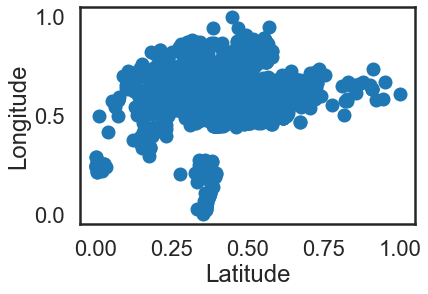

In [11]:
plt.scatter(lat_lon.iloc[:,0],lat_lon.iloc[:,1])
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

# Task 3

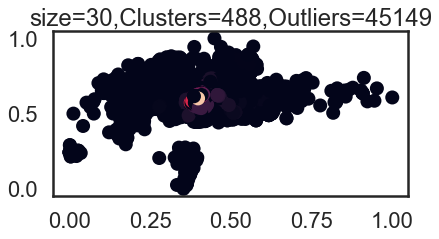

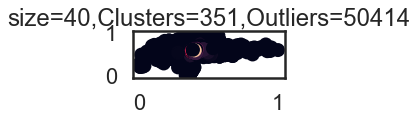

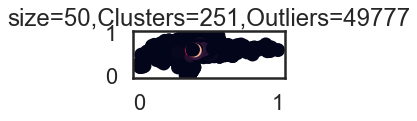

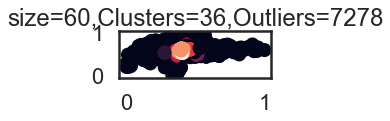

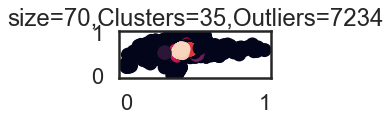

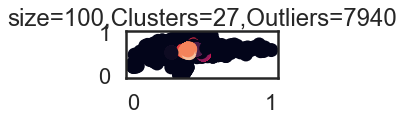

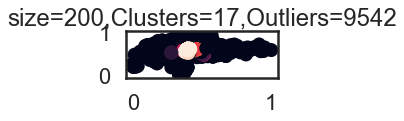

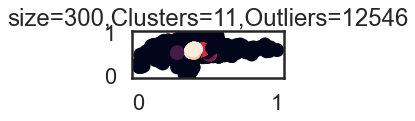

<Figure size 432x288 with 0 Axes>

In [12]:
c=[30,40,50,60,70,100,200,300]

clust=[]
outliers=[]

l=1
plt.figure(figsize=(14,14))
for i in c:
    plt.subplot(4,2,1)  
    l=l+1
    clusterer=hdbscan.HDBSCAN(min_cluster_size=i)
    clusterer.fit(lat_lon)
    clust.append(clusterer.labels_.max()+1)
    outliers.append(np.count_nonzero(clusterer.labels_==-1))
    plt.scatter(lat_lon.iloc[:,0],lat_lon.iloc[:,1],c=clusterer.labels_)
    plt.title(f"size={i},Clusters={clusterer.labels_.max()+1},Outliers={np.count_nonzero(clusterer.labels_==-1)}")
    plt.show()
plt.tight_layout()   

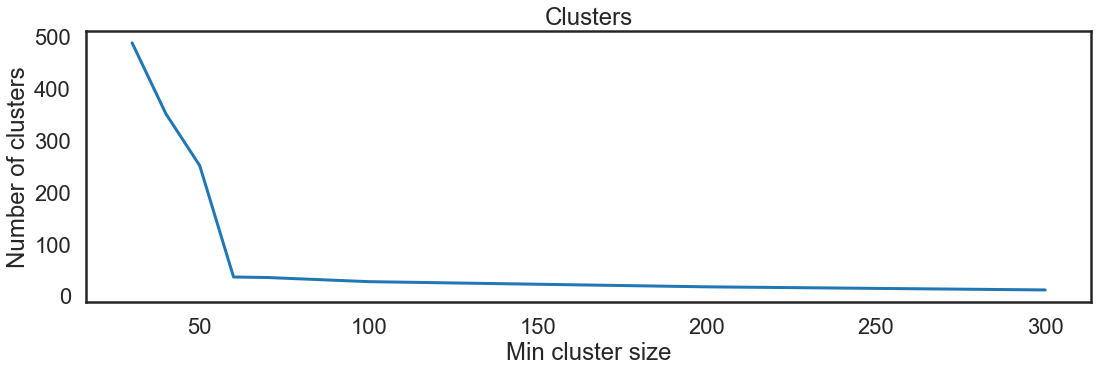

In [14]:
#plotting Clusters

plt.figure(figsize=(18,5))
plt.plot(c,clust)
plt.xlabel('Min cluster size')
plt.ylabel('Number of clusters')
plt.title('Clusters')
plt.show()

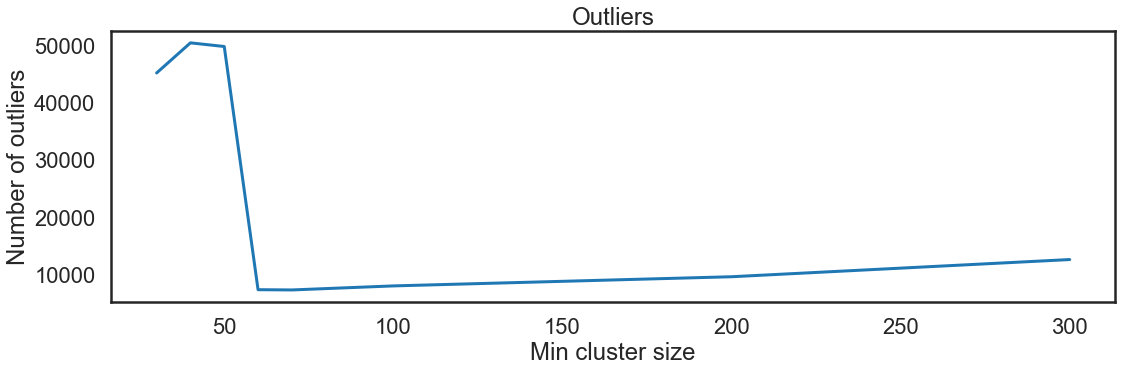

In [15]:
#plotting outliers

plt.figure(figsize=(18,5))
plt.plot(c,outliers)
plt.xlabel('Min cluster size')
plt.ylabel('Number of outliers')
plt.title('Outliers')
plt.show()

Cluster size 70 has balanced output with less outliers and more clusters

# TASK 4

In [17]:
s = 70
clusterer = hdbscan.HDBSCAN(min_cluster_size=s)
clusterer.fit(lat_lon)
lat_lon["clust"] = clusterer.labels_
lat_lon.head()

,Lon_meters,Lat_meters,clust
0,0.388705,0.583039,13
1,0.378421,0.568683,13
2,0.000000,0.244389,-1
3,0.393760,0.606264,13
4,0.277671,0.546447,4


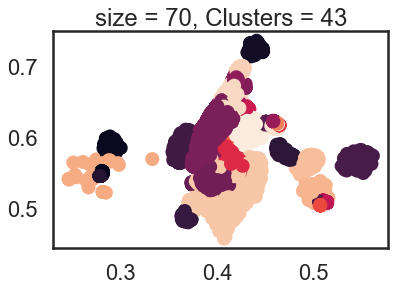

In [18]:
#ploting clusters
dat = lat_lon[lat_lon.clust >= 0]
plt.scatter(dat.iloc[:,0], dat.iloc[:,1], c = dat.clust)
plt.title(f"size = {s}, Clusters = {clusterer.labels_.max()+1}")
plt.show()

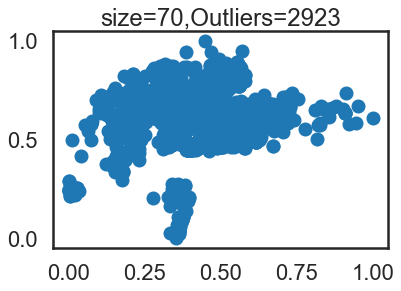

In [19]:
#plotting outliers
dout=lat_lon[lat_lon.clust==-1]
plt.scatter(dout.iloc[:,0],dout.iloc[:,1])
plt.title(f"size={s},Outliers={np.count_nonzero(clusterer.labels_==-1)}")
plt.show()

# TASK - 5

In [20]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 70).fit(lat_lon)
clusterer

HDBSCAN(min_cluster_size=70)

In [21]:
clusterer.outlier_scores_

array([3.04131740e-02, 6.62165294e-03, 9.19432295e-01, ...,
       9.71167823e-02, 5.89777149e-06, 1.78726026e-01])

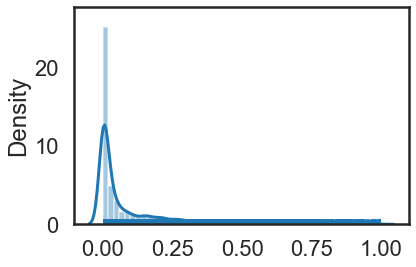

In [22]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug = True);

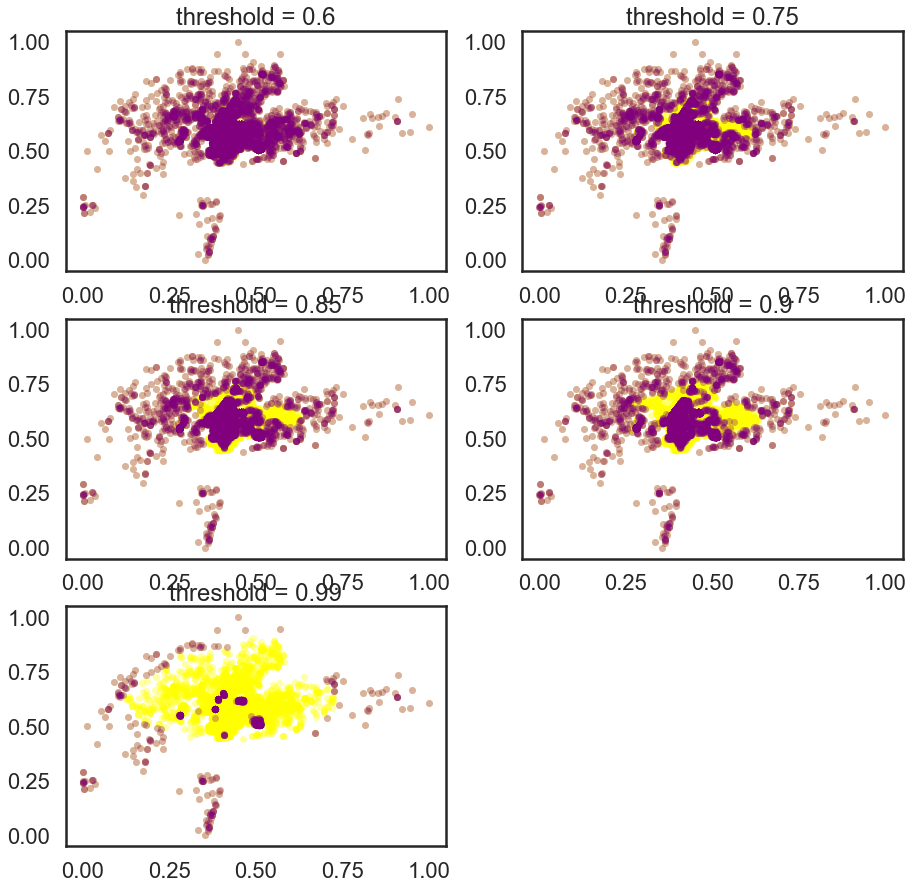

In [23]:
a = 1
fig = plt.figure(figsize = (15, 15))
quantiles = [0.6, 0.75, 0.85, 0.9, 0.99]

for q in quantiles:
    plt.subplot(3, 2, a)
    plt.title('threshold = '+str(q))
    threshold = pd.Series(clusterer.outlier_scores_).quantile(q)
    outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    dt=lat_lon.iloc[outliers]
    plt.scatter(lat_lon.iloc[:,0],lat_lon.iloc[:,1], s = 50, linewidth = 0, c = 'yellow', alpha = 0.35)
    plt.scatter(dt.iloc[:,0],dt.iloc[:,1], s = 50, linewidth = 0, c = 'purple', alpha = 0.30)    
    a = a+1